# Guided policy search cartpole solver

Last update: Nov 18

Current status: able to train a neural net controller to replicate an LQR policy to solve cartpole from a range of mild starting conditions $[(-10, -\pi/4, 0, 0) \rightarrow (10, \pi/4, 0, 0)]$ with a single mass parameter

Next steps: 

1. Update the network architecture to try to find a policy that can solve cartpole for a variety of mass parameters

2. Attempt to train a neural net controller to solve cartpole from a broader array of different starting positions

3. [OPT] Update the guided policy search to the more sophisticated method from the paper

## 1. Classes / definitions

In [702]:
'''
Import packages
'''

%matplotlib inline
import numpy as np
import theano
import theano.tensor as T
theano.config.exception_verbosity='high'
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import cPickle as pickle
import gzip
import os
import sys
import timeit


In [502]:
##########################
# NEURAL NETWORK CLASSES #
##########################

class HiddenLayer(object):
    """
    Implementation of hidden layer class. Source: http://deeplearning.net/tutorial/mlp.html#mlp.

    :type rng: numpy.random.RandomState
    :param rng: a random number generator used to initialize weights

    :type input: theano.tensor.dmatrix
    :param input: a symbolic tensor of shape (n_examples, n_in)

    :type n_in: int
    :param n_in: dimensionality of input

    :type n_out: int
    :param n_out: number of hidden units

    :type activation: theano.Op or function
    :param activation: Non linearity to be applied in the hidden layer

    """

    def __init__(self, rng, input, n_in, n_out, W=None, b=None, activation=T.tanh):
        self.input = input
        
        if W is None:
            if activation == theano.tensor.nnet.relu:
                W_values = np.asarray(
                    np.random.randn(n_in,n_out) * np.sqrt(2.0/n_in)
                    )
            else: 
                W_values = np.asarray(
                    rng.uniform(
                        low = -np.sqrt(6. / (n_in + n_out)), 
                        high = np.sqrt(6. / (n_in + n_out)), 
                        size = (n_in, n_out)
                    ),
                    dtype = theano.config.floatX)
            
                if activation == theano.tensor.nnet.sigmoid:
                    W_values *= 4
                
            W = theano.shared(value=W_values, name='W', borrow=True)
            
        if b is None:
            b_values = np.zeros((n_out,), dtype = theano.config.floatX)
            b = theano.shared(value = b_values, name='b', borrow=True)
        
        self.W = W
        self.b = b
        
        self.activation = activation
        
        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        
        self.params = [self.W, self.b]
        
class SimpleNN(object):
    ''' 
    Simple Neural Net class
    
    Single hidden layer net with one layer of hidden units and nonlinear activations. Top layer is linear
    Source: http://deeplearning.net/tutorial/mlp.html#mlp
    '''
    
    def __init__(self, rng, input, n_in, n_layers, n_hidden, n_out):
        """Initialize the parameters for the multilayer perceptron

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input (one minibatch)

        :type n_in: int
        :param n_in: number of input units
        
        :type n_hidden: int
        :param n_hidden: number of hidden units

        :type n_out: int
        :param n_out: number of output units

        """
        
        self.hiddenLayers = []
        
        for i in xrange(n_layers):
            if i == 0:
                layer_n_in = n_in
                layer_input = input
            else:
                layer_n_in = n_hidden
                layer_input = self.hiddenLayers[i-1].output
                
            layer_n_out = n_hidden
            
            hiddenLayer = HiddenLayer(
                rng = rng,
                input=layer_input,
                n_in = layer_n_in, 
                n_out = layer_n_out, 
                activation = T.nnet.relu
            )
            
            self.hiddenLayers.append(hiddenLayer)
        
        self.outputLayer = HiddenLayer(
            rng = rng,
            input = self.hiddenLayers[-1].output,
            n_in = n_hidden,
            n_out = n_out,
            activation = None
        )
             
        
        ## L1 and L2 regularization
        abs_W = np.array([])
        for i in xrange(n_layers):
            abs_W = np.append(abs_W, np.abs(self.hiddenLayers[i].W))
        abs_W = np.append(abs_W, np.abs(self.outputLayer.W))
        self.L1 = np.sum(abs_W)
        
        sq_W = 0.
        for i in xrange(n_layers):
            sq_W += T.sum(self.hiddenLayers[i].W**2)
        sq_W += T.sum(self.outputLayer.W**2)
        self.L2_sqr = sq_W
        
        # neg log likelihood is given by that of the output
        #self.negative_log_likelihood = ( self.logRegressionLayer.negative_log_likelihood )
        #self.errors = self.logRegressionLayer.errors
        
        self.params = []
        for i in xrange(n_layers):
            self.params = self.params + self.hiddenLayers[i].params
        self.params = self.params + self.outputLayer.params

        self.input = input
        
        self.output = self.outputLayer.output
        
    def meanSqErr(self, u):
        if u.ndim != self.output.ndim:
            raise TypeError(
                'u should have the same shape as self.output',
                ('u', u.type, 'self.output', self.output.type)
            )
        return T.mean( (self.output - u)**2 )
    
    def meanAbsErr(self, u):
        if u.ndim != self.output.ndim:
            raise TypeError(
                'u should have the same shape as self.output',
                ('u', u.type, 'self.output', self.output.type)
            )
        return T.mean( T.abs_(self.output - u) )


## 2. Simulation and trajectory generation

Here are some functions to use to generate trajectories

In [503]:
#################################################
# CARTPOLE SIMULATION AND TRAJECTORY GENERATION #
#################################################

def sim_cartpole(x0, u, dt=0.1, mc=10., mp=1.):
    '''
    Simulates cartpole starting at x0 with action u
    Modified from CS287 HW
    
    :type x0: np.array
    :param x0: starting point for the cartpole
    
    :type u: float or np.array
    :param u: action for the cartpole
    
    :type dt: float
    :param dt: time increment of simulation (default 0.1)
    
    :type mc: float
    :param mc: mass of the cart
    
    :type mp: float
    :param mp: mass of the pole
    '''
    
    def dynamics(x, u):
        l = 0.5
        g = 9.81
        T = 0.25
        s = np.sin(x[1])
        c = np.cos(x[1])
        
        xddot = (u + np.multiply(mp*s, l*np.power(x[3],2) + g*c))/(mc + mp*np.power(s,2))
        tddot = (-u*c - np.multiply(np.multiply(mp*l*np.power(x[3],2), c),s) - 
                 np.multiply((mc+mp)*g,s)) / (l * (mc + np.multiply(mp, np.power(s,2))))
        xdot = x[2:4]
        xdot = np.append(xdot, xddot)
        xdot = np.append(xdot, tddot)
        
        return xdot
    
    DT = 0.1
    t = 0
    while t < dt:
        current_dt = min(DT, dt-t)
        x0 = x0 + current_dt * dynamics(x0, u)
        t = t + current_dt
    
    return x0
    


def linearize_cartpole(x_ref, u_ref, dt, eps, mc=10., mp=1.):
    '''
    Linearizes the dynamics of cartpole around a reference point for use in an LQR controler.
    
    :type x_ref: np.array
    :param x_ref: reference point for linearization, i.e., the point to linearize around
    
    :type u_ref: np.array or float
    :param u_ref: reference action for initialization
    
    :type dt: float
    :type eps: float
    :type mc: float
    :type mp: float
    '''
    A = np.zeros([4,4])

    for i in range(4):
        increment = np.zeros([4,])
        increment[i] = eps
        A[:,i] = (sim_cartpole(x_ref + increment, u_ref, dt, mc, mp) - 
                  sim_cartpole(x_ref, u_ref, dt, mc, mp)) / (eps)
    
    B = (sim_cartpole(x_ref, u_ref + eps, dt, mc, mp) - sim_cartpole(x_ref, u_ref, dt, mc, mp)) / (eps)
    
    c = x_ref
    
    return A, B, c

def lqr_infinite_horizon(A, B, Q, R):
    '''
    Computes the LQR infinte horizon controller associated with linear dyamics A, B and quadratic cost Q, R
    '''
    nA = A.shape[0]

    if len(B.shape) == 1:
        nB = 1
    else:
        nB = B.shape[1]

    P_current = np.zeros([nA, nA])

    P_new = np.eye(nA)

    K_current = np.zeros([nB, nA])

    K_new= np.triu(np.tril(np.ones([nB,nA]),0),0)

    while np.linalg.norm(K_new - K_current, 2) > 1E-4:
        P_current = P_new
      
        K_current = K_new
        
        Quu = R + np.dot(np.dot( np.transpose(B), P_current), B)
        
        K_new = -np.linalg.inv(Quu) * np.dot(np.dot( np.transpose(B), P_current), A)
    
        P_new = Q + np.dot(np.dot( np.transpose(K_new), 
                                   R), 
                                   K_new) + np.dot(np.dot( np.transpose(A + np.dot(B.reshape(nA,1), K_new)),
                                                           P_current),
                                                           (A + np.dot(B.reshape(nA,1), K_new.reshape(1,nA)))
                          )
        
    return K_new, P_new, Quu


'''
Generate LQR trajectory for solving our simple cartpole problem
'''
x_ref = np.array([0, np.pi, 0, 0])
u_ref = 0.
A, B, c = linearize_cartpole(x_ref, u_ref, 0.1, 0.1)
Q = np.eye(4)
R = np.eye(1)
dt = 0.1
x_init = np.array([0, np.pi - np.pi/10, 0, 0])

K_inf, P_inf, Quu = lqr_infinite_horizon(A, B, Q, R)

x_lqr = np.zeros([4,500])
u_lqr = np.zeros([1,500])

x_lqr[:,0] = np.array([0, np.pi - np.pi/10, 0, 0])
u_lqr[:,0] = np.dot(K_inf, (x_lqr[:,0] - x_ref)) + u_ref

for i in range(499):
    x_lqr[:,i+1] = sim_cartpole(x_lqr[:,i], u_lqr[:,i], dt)
    u_lqr[:,i+1] = np.dot(K_inf, (x_lqr[:,i] - x_ref) ) + u_ref

    
'''
Function to generate samples from the guidance trajectory
Updated to take cart mass and pole mass as parameters
'''
def gen_traj_guidance(x_init, x_ref, u_ref, K, variance, traj_size, dt, mc=10., mp=1.):
    xs = len(x_ref)
    
    if type(u_ref) == float:
        us = 1
    else:
        us = len(u_ref)
    
    x_traj = np.zeros([xs, traj_size])
    u_traj = np.zeros([us, traj_size])
    
    x_traj[:,0] = x_init
    u_traj[:,0] = np.random.multivariate_normal(np.dot(K, (x_traj[:,0] - x_ref) ) + u_ref, variance)
    
    for t in range(traj_size-1):
        x_traj[:,t+1] = sim_cartpole(x_traj[:,t], u_traj[:,t], dt, mc, mp)
        u_mean = np.dot(K, (x_traj[:,t] - x_ref) ) + u_ref
        u_traj[:,t+1] = np.random.multivariate_normal(u_mean, variance)
    
    return x_traj, u_traj

x_init_options = [
    np.array([0, np.pi - np.pi/4, 0, 0]),
    np.array([10, np.pi - np.pi/4, 0, 0]),
    np.array([-10, np.pi - np.pi/4, 0, 0]),
    np.array([0, np.pi + np.pi/4, 0, 0]),
    np.array([10, np.pi + np.pi/4, 0, 0]),
    np.array([-10, np.pi + np.pi/4, 0, 0]),
]

def sim_cartpole_ext(x0, u, dt):
    ''' 
    Simulates cartpole given an x0 provided that also encodes mc and mp in the last 2 entries
    '''
    mc = np.array(x0[-2])
    mp = np.array(x0[-1])
    xnew = np.array(x0)
    xnew[:4] = sim_cartpole(x0[:4], u, dt, mc, mp)
    return xnew

def linearize_cartpole_ext(x_ref, u_ref, dt, eps):
    ''' 
    Linearizes dynamics of cartpole where the x0 provided that also encodes mc and mp in the last 2 entries
    '''
    A = np.eye(6)
    B = np.zeros([6,])
    A[:4,:4], B[:4], c = linearize_cartpole(x_ref[:4], u_ref, dt, eps, x_ref[-2], x_ref[-1])
    c = x_ref
    return A, B, c

def gen_traj_guidance_ext(x_init, K, Quu, 
                          x_ref = np.array([0, np.pi, 0, 0]),
                          u_ref = 0.,
                          traj_size=500, dt = 0.01):
    '''
    Generate samples from the LQR policy
    '''
    
    #print x_init
    xs = len(x_init)
    
    if type(u_ref) == float:
        us = 1
    else:
        us = len(u_ref)
    
    #print x_init
    if len(x_ref) < xs:
        x_ref_ext = np.array(x_init)
        x_ref_ext[:4] = x_ref
    else:
        x_ref_ext = x_ref
    
    #print x_init
    x_traj = np.zeros([xs, traj_size])
    u_traj = np.zeros([us, traj_size])
    
    x_traj[:,0] = x_init
    u_traj[:,0] = np.random.multivariate_normal(np.dot(K, (x_traj[:,0] - x_ref_ext) ) + u_ref, Quu)
    
    #print x_init
    for t in range(traj_size-1):
        x_traj[:,t+1] = sim_cartpole_ext(x_traj[:,t], u_traj[:,t], dt)
        u_mean = np.dot(K, (x_traj[:,t] - x_ref_ext) ) + u_ref
        u_traj[:,t+1] = np.random.multivariate_normal(u_mean, Quu)
    
    return x_traj, u_traj


In [504]:
x_lqr[:,-1]

array([ -7.52330002e-05,   3.14159181e+00,  -4.65988084e-06,
         3.18406685e-07])

## 3. Neural network training

In [608]:
###########################
# NEURAL NETWORK TRAINING #
###########################

def train_NN(learning_rate=0.01, L1_reg=0.0, L2_reg=0.0, n_epochs=100, batch_size=20, n_layers=1, n_hidden=20, 
             LQR_controller=K_inf, LQR_start=x_init, LQR_var=Quu, num_traj=10, ext=False, learning_rule=None,
             dt=0.005, print_interval=10, traj_size=500):

    #########################
    # GENERATE TRAJECTORIES #
    #########################
    
    x_traj_list = []
    u_traj_list = []
    # Generate num_traj sample trajectories from our LQR policy for each of training, validation, and test
    if type(LQR_start) == list:
        n_guidance = len(LQR_start)
        for i in range(3): # training, validation, test
            for j in range(n_guidance): # starting positions
                for k in range(num_traj): # generate this many trajectories
                    if ext:
                        if len(LQR_start) != len(LQR_controller):
                            raise TypeError(
                                'for extended version, please provide a LQR controller and a variance for each x_init'
                            )
                            
                        x_traj1, u_traj1 = gen_traj_guidance_ext(LQR_start[j], LQR_controller[j], LQR_var[j],
                                                                traj_size=traj_size, dt=dt)
                        x_traj_list.append(x_traj1)
                        u_traj_list.append(u_traj1)
                    else:    
                        x_traj1, u_traj1 = gen_traj_guidance(LQR_start[j], x_ref, u_ref, 
                                                             LQR_controller, LQR_var, traj_size, dt)
                        x_traj_list.append(x_traj1)
                        u_traj_list.append(u_traj1)
    else:
        n_guidance = 1
        for t in range(3*num_traj):
            x_traj1, u_traj1 = gen_traj_guidance(LQR_start, x_ref, u_ref, LQR_controller, LQR_var, traj_size, dt)
            x_traj_list.append(x_traj1)
            u_traj_list.append(u_traj1)
        
    train_set_x = theano.shared(
        value = np.concatenate(x_traj_list[:n_guidance*num_traj], axis=1).T, 
        name='tr_x', borrow=True)
    train_set_u = theano.shared(
        value = np.concatenate(u_traj_list[:n_guidance*num_traj], axis=1).T, 
        name='tr_u', borrow=True)
    valid_set_x = theano.shared(
        np.concatenate(x_traj_list[n_guidance*num_traj:2*n_guidance*num_traj], axis=1).T, 
        name='v_x', borrow=True)
    valid_set_u = theano.shared(
        np.concatenate(u_traj_list[n_guidance*num_traj:2*n_guidance*num_traj], axis=1).T, 
        name='v_u', borrow=True)
    test_set_x = theano.shared(
        np.concatenate(x_traj_list[2*n_guidance*num_traj:3*n_guidance*num_traj], axis=1).T, 
        name='te_x', borrow=True)
    test_set_u = theano.shared(
        np.concatenate(u_traj_list[n_guidance*num_traj:2*n_guidance*num_traj], axis=1).T, 
        name='te_u', borrow=True)
    
    ## DEBUGGIN
    ## return train_set_x, train_set_u, valid_set_x, valid_set_u, test_set_x, test_set_u
    
    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] / batch_size
    n_test_batches = test_set_x.get_value(borrow=True).shape[0] / batch_size

    ###############
    # BUILD MODEL #
    ###############
    print '... building the model'

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as a matrix of positions
    u = T.matrix('u')  # control inputs are a 1d matrix.

    rng = np.random.RandomState(1234)

    if ext:
        n_in = 6
    else:
        n_in = 4
        
    # construct the MLP class
    classifier = SimpleNN(
        rng=rng,
        input=x,
        n_in=n_in,
        n_layers=n_layers,
        n_hidden=n_hidden,
        n_out=1
    )
    
    ## DEBUG
    ## return classifier

    # define cost function
    ## NEED TO FIX
    cost = (
        classifier.meanSqErr(u)
        #+ L1_reg * classifier.L1
        + L2_reg * classifier.L2_sqr
    )
    
    #return cost
    
    # compile a Theano function that computes the mistakes that are made by the model on a minibatch
    test_model = theano.function(
        inputs=[index],
        outputs=cost,
        givens={
            x: test_set_x[index * batch_size:(index + 1) * batch_size],
            u: test_set_u[index * batch_size:(index + 1) * batch_size]
        }
    )

    validate_model = theano.function(
        inputs=[index],
        outputs=cost,
        givens={
            x: valid_set_x[index * batch_size:(index + 1) * batch_size],
            u: valid_set_u[index * batch_size:(index + 1) * batch_size]
        }
    )
    
    # calculate gradient
    gparams = [T.grad(cost, param) for param in classifier.params]
    
    ## DEBUG
    ## return classifier, gparams
    
    # rule for parameter updates
    updates = [
        (param, param- learning_rate * gparam)
        for param, gparam in zip(classifier.params, gparams)
    ]
    
    # return cost and update parameters
    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            u: train_set_u[index * batch_size: (index + 1) * batch_size]
        }
    )
    
    ###############
    # TRAIN MODEL #
    ###############
    print '... training'
    
    # record training, validation, and test costs to be returned to user
    training_losses = np.array([]) ##
    validation_losses = np.array([]) ##
    test_losses = np.array([]) ##

    # early-stopping parameters
    patience = 10000000  # look as this many examples regardless (10000)
    patience_increase = 2  # wait this much longer when a new best is found
    improvement_threshold = 0.995  # a relative improvement of this much is considered significant
    validation_frequency = min(n_train_batches, patience / 2)

    best_validation_loss = np.inf
    test_score = np.inf
    best_iter = 0
    test_score = 0.
    start_time = timeit.default_timer()

    epoch = 0
    done_looping = False
    
    avg_training_loss = 0.
    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in xrange(n_train_batches):
            # update our sum of training losses for this minibatch
            minibatch_avg_cost = train_model(minibatch_index) ##
            avg_training_loss += minibatch_avg_cost ##
            
            # iteration number
            iter = (epoch - 1) * n_train_batches + minibatch_index

            if (iter + 1) % validation_frequency == 0:
                # update our list of training losses
                training_losses = np.append(training_losses, avg_training_loss / validation_frequency)
                avg_training_loss = 0
                
                # apply our rule to update the learning rate
                if learning_rule != None:
                    if (iter / validation_frequency == learning_rule[0]):
                        learning_rate = learning_rule[1]*learning_rate
                
                # compute validation error
                these_validation_losses = [validate_model(i) for i
                                     in xrange(n_valid_batches)]
                this_validation_loss = np.mean(these_validation_losses)
                
                # update our list of validation losses
                validation_losses = np.append(validation_losses, this_validation_loss)
                
              

                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:
                    #improve patience if loss improvement is good enough
                    if (
                        this_validation_loss < best_validation_loss *
                        improvement_threshold
                    ):
                        patience = max(patience, iter * patience_increase)

                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    epoch_test_losses = [test_model(i) for i
                                   in xrange(n_test_batches)]
                    test_score = np.mean(epoch_test_losses)
                    
                    # update our list of test scores
                    test_losses = np.append(test_losses, test_score)
                        
                # print progress if we are at the print interval
                if (iter + 1) % (validation_frequency * print_interval) == 0:
                    print(
                        ('epoch %i, minibatch %i/%i, validation error %f, test error of best model %f') %
                        (
                            epoch,
                            minibatch_index + 1,
                            n_train_batches,
                            this_validation_loss,
                            test_score
                        )
                    )

            if patience <= iter:
                done_looping = True
                break

    end_time = timeit.default_timer()
    print(('Optimization complete. Best validation score of %f '
           'obtained at iteration %i, with test performance %f') %
          (best_validation_loss, best_iter + 1, test_score))
    print 'The code ran for %d epochs, with %f epochs/sec' % (
        epoch, 1.*epoch / (end_time - start_time))
    
    return x, classifier, training_losses, validation_losses, test_losses, train_set_x, valid_set_x, train_set_u, valid_set_u
    
    
#learning_rate=0.01, L1_reg=0.0, L2_reg=0.0, n_epochs=100, batch_size=20, n_layers=1, n_hidden=20, 
#             LQR_controller=K_inf, LQR_start=x_init, LQR_var=Quu, num_traj=10, ext=False, learning_rule=None,
#             dt=0.005, print_interval=10, traj_size=500

def optimize_NN_hyperparameters(LQR_controller, LQR_start, LQR_var, 
                                lr_range=[0.1,0.01],
                                nlyr_range=[1,1],
                                nhidden_range=[20,20],
                                batch_size_range=[50,50],
                                learning_rules=[None, None],
                                n_epochs=5, num_traj=10, ext=False, dt=0.05, traj_size=500):
    tr_loss = np.zeros([n_epochs, len(lr_range)])
    val_loss = np.zeros([n_epochs, len(lr_range)])
    
    assert ( (len(lr_range) == len(nlyr_range)) & 
             (len(lr_range) == len(nhidden_range)) & 
             (len(lr_range) == len(batch_size_range))
           )
    
    for i in range(len(lr_range)):
        x, policy, training_losses, validation_losses, test_losses, train_set_x, valid_set_x, train_set_u, valid_set_u = train_NN(
            learning_rate=lr_range[i],
            L1_reg = 0., L2_reg = 0., n_epochs=n_epochs,
            batch_size=batch_size_range[i],
            n_layers=nlyr_range[i],
            n_hidden=nhidden_range[i],
            LQR_controller=LQR_controller, LQR_start=LQR_start, LQR_var=LQR_var, num_traj=num_traj,
            ext=ext, 
            learning_rule=learning_rules[i], 
            dt=dt, print_interval=100*n_epochs, traj_size=traj_size
        )
        
        tr_loss[:,i] = training_losses
        val_loss[:,i] = validation_losses
    return tr_loss, val_loss

## 4. Network training

### 4A. Train a network on unextended cartpole for 1 starting point. 

Here, we train a neural net to be able to solve cartpole staring from $(0, \pi - \frac{\pi}{10}, 0, 0)$.

In [446]:
'''
4A. Train for single starting point: (0, \pi - \pi/10, 0, 0)
'''
x, policy, tr_losses, val_losses, te_losses, train_set, val_set, train_u, val_u = train_NN(
    learning_rate=0.0005, L1_reg=0.0, L2_reg=0.0, n_epochs=10000, batch_size=50, n_layers=1, n_hidden=20, 
    LQR_controller=K_inf, LQR_start=x_init, LQR_var=Quu, num_traj=20, ext=False, learning_rule=None,
    dt=0.1, print_interval=50, traj_size=500)

... building the model
... training
epoch 50, minibatch 200/200, validation error 47.481979, test error of best model 49.078870
epoch 100, minibatch 200/200, validation error 42.982706, test error of best model 45.548152
epoch 150, minibatch 200/200, validation error 36.809680, test error of best model 39.785865
epoch 200, minibatch 200/200, validation error 29.592378, test error of best model 33.213979
epoch 250, minibatch 200/200, validation error 24.369133, test error of best model 30.049646
epoch 300, minibatch 200/200, validation error 26.669485, test error of best model 29.103445
epoch 350, minibatch 200/200, validation error 30.315098, test error of best model 29.103445
epoch 400, minibatch 200/200, validation error 30.691285, test error of best model 29.103445
epoch 450, minibatch 200/200, validation error 29.379417, test error of best model 29.103445
epoch 500, minibatch 200/200, validation error 27.437319, test error of best model 29.103445
epoch 550, minibatch 200/200, valid

3.77431678916


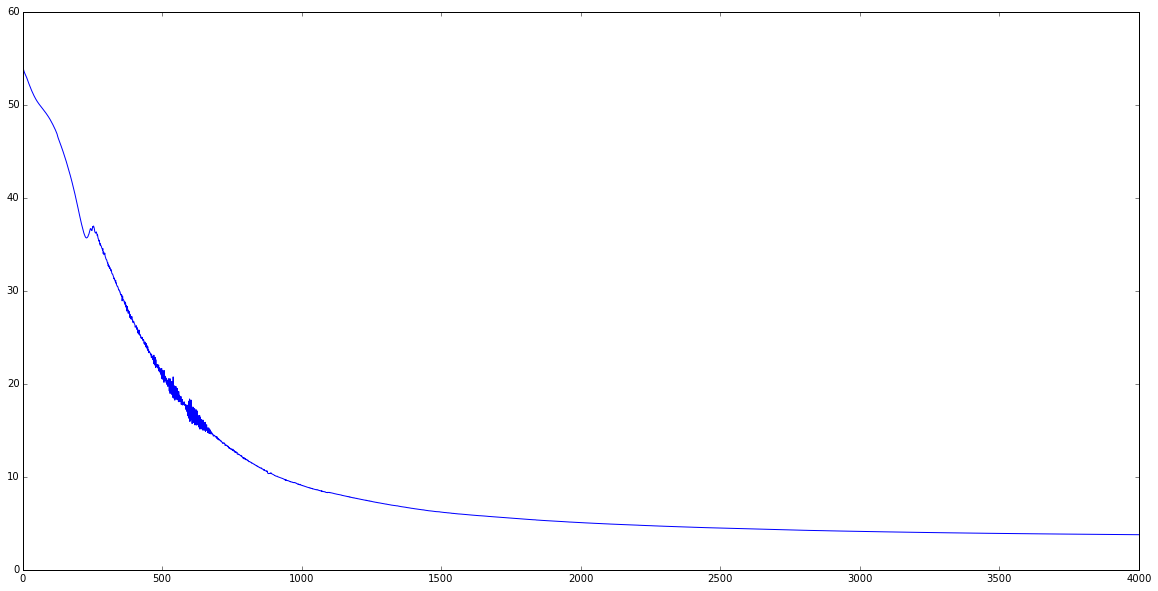

In [514]:
'''
4A. Plot training loss
'''
plt.figure(figsize=(20,10))
plt.plot(tr_losses)

[ -3.25114017e-01   3.14160245e+00   2.36066158e-04  -1.10308582e-06]


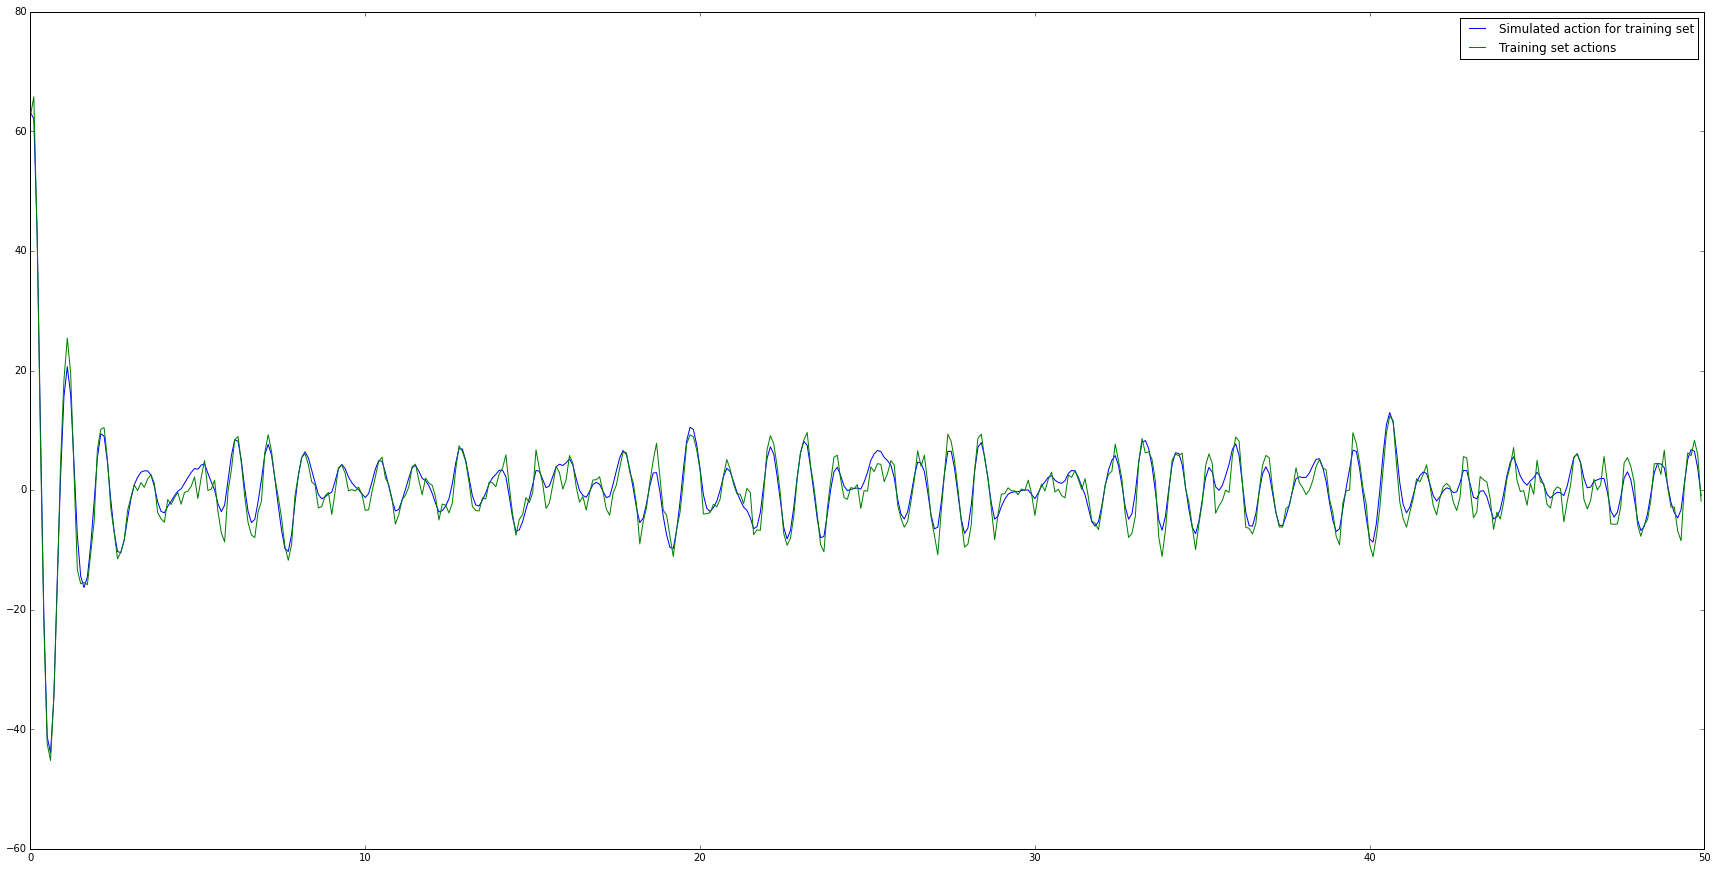

In [515]:
'''
4A. Simulate the resulting policy
'''
feed_forward = theano.function(
    inputs=[x],
    outputs=policy.output)

dt = 0.1
x_init2 = np.array([0, np.pi-np.pi/10, 0, 0])

x_sim = np.zeros([4,500])
x_sim[:,0] = x_init2

u_sim = np.zeros([500,])
u_sim[0] = feed_forward(x_sim[:,0].reshape([1,4]))

for t in range(499):
    x_sim[:,t+1] = sim_cartpole(x_sim[:,t], u_sim[t], dt)
    u_sim[t+1] = feed_forward(x_sim[:,t+1].reshape([1,4]))

u_1 = np.zeros([500,])
for t in range(500):
    u_1[t] = feed_forward(train_set.get_value().T[:,t].reshape([1,4]))
    
tt = dt*np.arange(0,500)
plt.figure(figsize=(30,15))
#plt.plot(tt, u_lqr.flatten(), label="LQR action")
#plt.plot(tt, u_sim.flatten(), label="Simulated action for deterministic part")
plt.plot(tt, u_1.flatten(), label="Simulated action for training set")
plt.plot(tt, train_u.get_value().flatten()[:500], label="Training set actions")
plt.legend()

#plt.plot(u_sim)

print x_sim[:,-1]

### 4B. Train a network on unextended cartpole with a range of staring positions

In [429]:
'''
4B. Initialize variables
'''

x_init_choices = [
    np.array([0, np.pi - np.pi/4, 0, 0, 10.,1.]),
    np.array([10, np.pi - np.pi/4., 0, 0, 10.,1.]),
    np.array([-10, np.pi - np.pi/4., 0, 0,10.,1.]),
    np.array([0, np.pi + np.pi/4., 0, 0,10.,1.]),
    np.array([10, np.pi + np.pi/4., 0, 0,10.,1.]),
    np.array([-10, np.pi + np.pi/4., 0, 0,10.,1.]),
]

Q_ext = np.eye(6)
R_ext = np.eye(1)
x_ref_ext =  np.array([0, np.pi, 0, 0, 10., 1.])
u_ref_ext = 0.
A_ext, B_ext, c_ext = linearize_cartpole_ext(x_ref_ext, u_ref_ext, 0.1, 0.1)
K_ext, P_ext, Quu_ext = lqr_infinite_horizon(A_ext, B_ext, Q_ext, R_ext)
K_choices = [K_ext, K_ext, K_ext, K_ext, K_ext, K_ext]
Quu_choices = [Quu_ext, Quu_ext, Quu_ext, Quu_ext, Quu_ext, Quu_ext]



In [437]:
'''
4B. Train net
'''
x, policy = train_NN(
    learning_rate=0.00005, 
    L1_reg=0.0, L2_reg=0.0000, 
    n_epochs=1000, batch_size=50, n_hidden=20, 
    LQR_controller=K_choices, LQR_start=x_init_choices, LQR_var=Quu_choices, 
    num_traj=10, ext=True)

KeyboardInterrupt: 

In [13]:
'''
4B. Simulate net
'''

feed_forward = theano.function(
    inputs=[x],
    outputs=policy.output)

dt = 0.1
x_init2 = np.array([0, np.pi-np.pi/20, 0, 0, 10, 1])

x_sim = np.zeros([6,500])
x_sim[:,0] = x_init2

u_sim = np.zeros([500,])
u_sim[0] = feed_forward(x_sim[:,0].reshape([1,6]))

for t in range(499):
    x_sim[:,t+1] = sim_cartpole_ext(x_sim[:,t], u_sim[t], dt)
    u_sim[t+1] = np.random.normal(feed_forward(x_sim[:,t+1].reshape([1,6])),1)

NameError: name 'x' is not defined

### 4c. Train a network on extended cartpole on a range of starting scenarios

In [573]:
'''
4C. Initialize variables
'''
Q_ext = np.eye(6)
R_ext = np.eye(1)
x_ref_ext1 =  np.array([0, np.pi, 0, 0, 10., 1.])
u_ref_ext1 = 0.
A_ext1, B_ext1, c_ext1 = linearize_cartpole_ext(x_ref_ext1, u_ref_ext1, 0.1, 0.1)
K_ext1, P_ext1, Quu_ext1 = lqr_infinite_horizon(A_ext1, B_ext1, Q_ext, R_ext)
x_ref_ext2 =  np.array([0, np.pi, 0, 0, 20., 2.])
u_ref_ext2 = 0.
A_ext2, B_ext2, c_ext2 = linearize_cartpole_ext(x_ref_ext2, u_ref_ext2, 0.1, 0.1)
K_ext2, P_ext2, Quu_ext2 = lqr_infinite_horizon(A_ext2, B_ext2, Q_ext, R_ext)

x_init_choices = [
    np.array([0, np.pi - np.pi/10, 0, 0, 10.,1.]),
    np.array([10, np.pi - np.pi/4., 0, 0, 10.,1.]),
    np.array([-10, np.pi - np.pi/4., 0, 0,10.,1.]),
    np.array([0, np.pi + np.pi/4., 0, 0,10.,1.]),
    np.array([10, np.pi + np.pi/4., 0, 0,10.,1.]),
    np.array([-10, np.pi + np.pi/4., 0, 0,10.,1.]),
    #np.array([0, np.pi - np.pi/10, 0, 0, 15.,1.5]),
    #np.array([10, np.pi - np.pi/4., 0, 0, 100.,10.]),
    #np.array([-10, np.pi - np.pi/4., 0, 0,100.,10.]),
    #np.array([0, np.pi + np.pi/4., 0, 0,100.,10.]),
    #np.array([10, np.pi + np.pi/4., 0, 0,100.,10.]),
    #np.array([-10, np.pi + np.pi/4., 0, 0,100.,10.]),
]


K_choices = [K_ext1, K_ext1, K_ext1, K_ext1, K_ext1, K_ext1,] 
#             K_ext2, K_ext2, K_ext2, K_ext2, K_ext2, K_ext2]
Quu_choices = [Quu_ext1, Quu_ext1, Quu_ext1, Quu_ext1, Quu_ext1, Quu_ext1,]
#               Quu_ext2, Quu_ext2, Quu_ext2, Quu_ext2, Quu_ext2, Quu_ext2]
#K_choices = [K_ext1] #, K_ext2]
#Quu_choices = [Quu_ext1] #, Quu_ext2]


In [575]:
'''
3C. Train network
'''
x, policy, tr_losses, val_losses, te_losses, train_set, val_set, train_u, val_u = train_NN(
    learning_rate=0.00005, L1_reg=0.0, L2_reg=0.00001, n_epochs=5000, batch_size=100, n_layers=1, n_hidden=20, 
    LQR_controller=K_choices, LQR_start=x_init_choices, LQR_var=Quu_choices, num_traj=10, ext=True, learning_rule=None,
    dt=0.1, print_interval=100, traj_size=500)

... building the model
... training
epoch 100, minibatch 300/300, validation error 73.446210, test error of best model 83.031977
epoch 200, minibatch 300/300, validation error 14.093626, test error of best model 31.027367
epoch 300, minibatch 300/300, validation error 21.061333, test error of best model 30.049824
epoch 400, minibatch 300/300, validation error 5.644956, test error of best model 30.049824
epoch 500, minibatch 300/300, validation error 5.552871, test error of best model 31.137132
epoch 600, minibatch 300/300, validation error 4.998306, test error of best model 30.710263
epoch 700, minibatch 300/300, validation error 4.788736, test error of best model 30.534398
epoch 800, minibatch 300/300, validation error 4.676362, test error of best model 30.431208
epoch 900, minibatch 300/300, validation error 4.629182, test error of best model 30.373187
epoch 1000, minibatch 300/300, validation error 4.630920, test error of best model 30.373187
epoch 1100, minibatch 300/300, validatio

[array([[ 2.23925216]]), array([[ 2.23925216]]), array([[ 2.23925216]]), array([[ 2.23925216]]), array([[ 2.23925216]]), array([[ 2.23925216]])]
[  4.60484113e-01   3.14159855e+00   1.95911658e-04  -4.44729949e-08
   1.00000000e+01   1.00000000e+00]


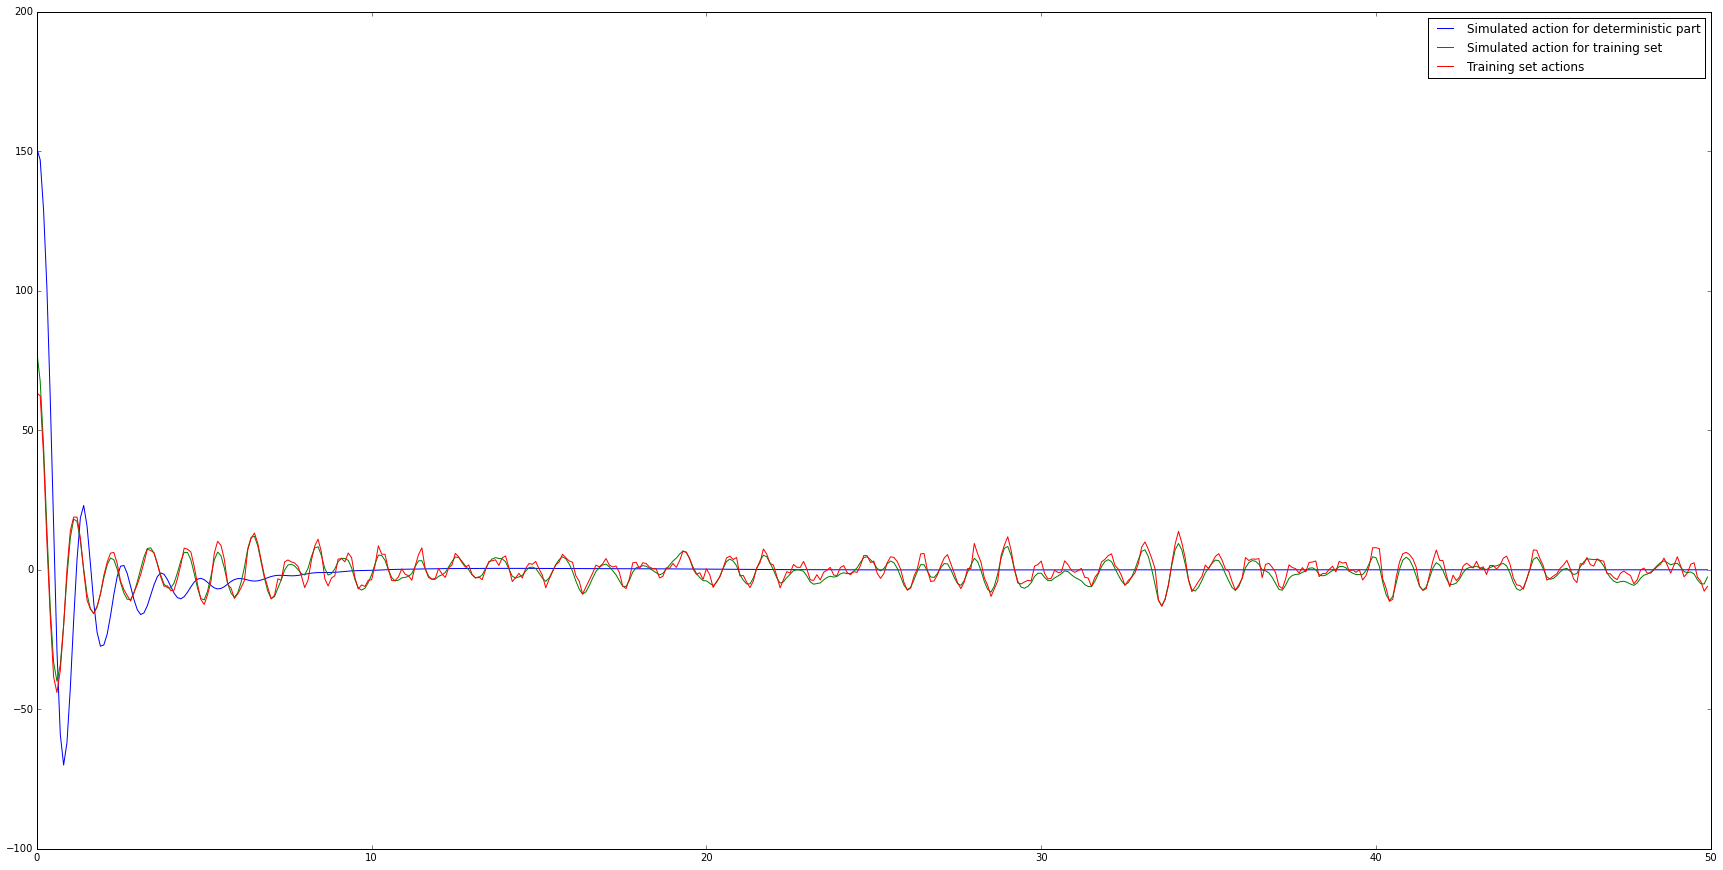

In [584]:
'''
4C. Simulate the resulting policy
'''
feed_forward = theano.function(
    inputs=[x],
    outputs=policy.output)

print Quu_choices
dt = 0.1
x_init2 = np.array([-10, np.pi-np.pi/4, 0, 0,10.,1.])

x_sim = np.zeros([6,500])
x_sim[:,0] = x_init2

u_sim = np.zeros([500,])
u_sim[0] = feed_forward(x_sim[:,0].reshape([1,6]))

for t in range(499):
    x_sim[:,t+1] = sim_cartpole_ext(x_sim[:,t], u_sim[t], dt)
    u_sim[t+1] = feed_forward(x_sim[:,t+1].reshape([1,6]))

u_1 = np.zeros([500,])
for t in range(500):
    u_1[t] = feed_forward(train_set.get_value().T[:,t].reshape([1,6]))
    
tt = dt*np.arange(0,500)
plt.figure(figsize=(30,15))
#plt.plot(tt, u_lqr.flatten(), label="LQR action")
plt.plot(tt[:500], u_sim.flatten()[:500], label="Simulated action for deterministic part")
plt.plot(tt, u_1.flatten(), label="Simulated action for training set")
plt.plot(tt, train_u.get_value().flatten()[:500], label="Training set actions")
plt.legend()

#plt.plot(u_sim)

print x_sim[:,-1]

### 4D. Two cartpoles, single starting position

In [676]:
'''
4D. Initialize variables
'''
Q_ext = np.eye(6)
R_ext = np.eye(1)
x_ref_ext1 =  np.array([0, np.pi, 0, 0, 10., 1.])
u_ref_ext1 = 0.
A_ext1, B_ext1, c_ext1 = linearize_cartpole_ext(x_ref_ext1, u_ref_ext1, 0.1, 0.1)
K_ext1, P_ext1, Quu_ext1 = lqr_infinite_horizon(A_ext1, B_ext1, Q_ext, R_ext)
x_ref_ext2 =  np.array([0, np.pi, 0, 0, 11., 1.1])
u_ref_ext2 = 0.
A_ext2, B_ext2, c_ext2 = linearize_cartpole_ext(x_ref_ext2, u_ref_ext2, 0.1, 0.1)
K_ext2, P_ext2, Quu_ext2 = lqr_infinite_horizon(A_ext2, B_ext2, Q_ext, R_ext)

x_init_choices = [
    np.array([0, np.pi - np.pi/10, 0, 0, 10.,1.]),
    #np.array([10, np.pi - np.pi/4., 0, 0, 10.,1.]),
    #np.array([-10, np.pi - np.pi/4., 0, 0,10.,1.]),
    #np.array([0, np.pi + np.pi/4., 0, 0,10.,1.]),
    #np.array([10, np.pi + np.pi/4., 0, 0,10.,1.]),
    #np.array([-10, np.pi + np.pi/4., 0, 0,10.,1.]),
    np.array([0, np.pi - np.pi/10, 0, 0, 11,1.1]),
    #np.array([10, np.pi - np.pi/4., 0, 0, 100.,10.]),
    #np.array([-10, np.pi - np.pi/4., 0, 0,100.,10.]),
    #np.array([0, np.pi + np.pi/4., 0, 0,100.,10.]),
    #np.array([10, np.pi + np.pi/4., 0, 0,100.,10.]),
    #np.array([-10, np.pi + np.pi/4., 0, 0,100.,10.]),
]


#K_choices = [K_ext1, K_ext1, K_ext1, K_ext1, K_ext1, K_ext1,] 
#             K_ext2, K_ext2, K_ext2, K_ext2, K_ext2, K_ext2]
#Quu_choices = [Quu_ext1, Quu_ext1, Quu_ext1, Quu_ext1, Quu_ext1, Quu_ext1,]
#               Quu_ext2, Quu_ext2, Quu_ext2, Quu_ext2, Quu_ext2, Quu_ext2]
K_choices = [K_ext1, K_ext2]
Quu_choices = [Quu_ext1, Quu_ext2]


In [622]:
'''
4D. Hyperparameter optimization
'''

lr_range = [0.00008, 0.00005, 0.00002]
nlyr_range = [3, 3, 3,]
nhidden_range = [40, 40, 40,]
batch_size_choices = [100, 100, 100, ]
batch_size_range = batch_size_choices
learning_rules = [None, None, None, ]

tr_loss, val_loss = optimize_NN_hyperparameters(
    K_choices, x_init_choices, Quu_choices, 
    lr_range,
    nlyr_range,
    nhidden_range,
    batch_size_range,
    learning_rules,
    n_epochs=500,num_traj=10, ext=True, dt=0.1, traj_size=500)

... building the model
... training
Optimization complete. Best validation score of 30.242341 obtained at iteration 45000, with test performance 32.718777
The code ran for 500 epochs, with 13.710711 epochs/sec
... building the model
... training
Optimization complete. Best validation score of 52.712673 obtained at iteration 11200, with test performance 54.449117
The code ran for 500 epochs, with 12.993729 epochs/sec
... building the model
... training
Optimization complete. Best validation score of 53.234055 obtained at iteration 40700, with test performance 54.706439
The code ran for 500 epochs, with 11.598570 epochs/sec


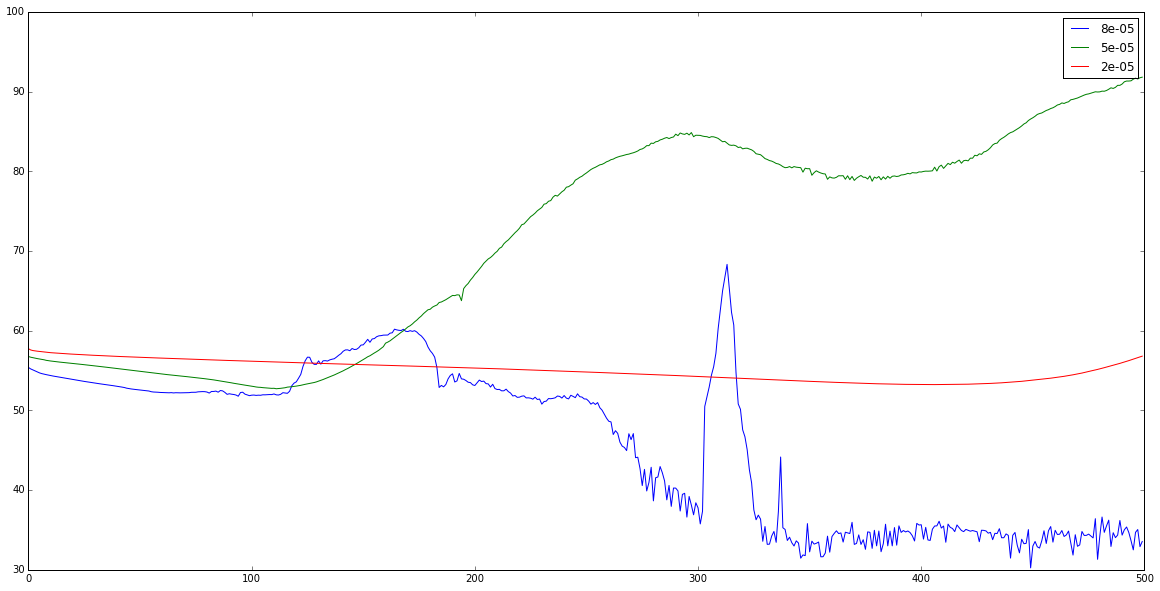

In [640]:
plt.figure(figsize=(20,10))
plt.plot(val_loss)
plt.legend(lr_range)

In [692]:
'''
4D. Train network
'''
x, policy, tr_losses, val_losses, te_losses, train_set, val_set, train_u, val_u = train_NN(
    learning_rate=0.000005, L1_reg=0.0, L2_reg=0.0, n_epochs=35000, batch_size=100, n_layers=3, n_hidden=40, 
    LQR_controller=K_choices, LQR_start=x_init_choices, LQR_var=Quu_choices, num_traj=20, ext=True, 
    learning_rule=(7500, 0.5),
    dt=0.1, print_interval=1000, traj_size=500)

... building the model
... training
epoch 1000, minibatch 200/200, validation error 77.865740, test error of best model 54.284976
epoch 2000, minibatch 200/200, validation error 450.552182, test error of best model 54.284976
epoch 3000, minibatch 200/200, validation error 73.812118, test error of best model 54.284976
epoch 4000, minibatch 200/200, validation error 30.842200, test error of best model 36.651674
epoch 5000, minibatch 200/200, validation error 28.617363, test error of best model 33.587586
epoch 6000, minibatch 200/200, validation error 31.360702, test error of best model 33.587586
epoch 7000, minibatch 200/200, validation error 47.960690, test error of best model 33.587586
epoch 8000, minibatch 200/200, validation error 83.689763, test error of best model 33.587586
epoch 9000, minibatch 200/200, validation error 118.022997, test error of best model 33.587586
epoch 10000, minibatch 200/200, validation error 132.698547, test error of best model 33.587586
epoch 11000, minibat

In [733]:
'''
Save the policy
'''
with open(r"policy_4D.pickle","wb") as output_file:
    pickle.dump(policy, output_file)

2.95337265149


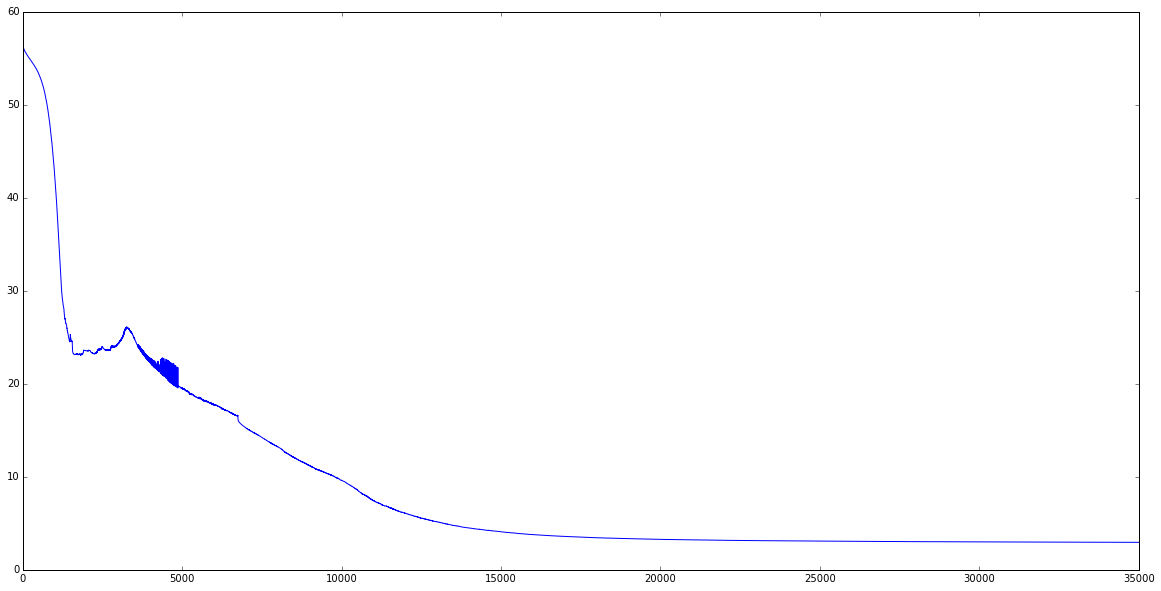

In [731]:
'''
Plot training loss
'''
print tr_losses[-1]
plt.figure(figsize=(20,10))
plt.plot(tr_losses)

[array([[ 2.23925216]]), array([[ 2.23442733]])]
[ -3.59546795e-02   3.14054146e+00  -2.67008090e-02  -9.64782440e-04
   1.00000000e+01   1.00000000e+00]


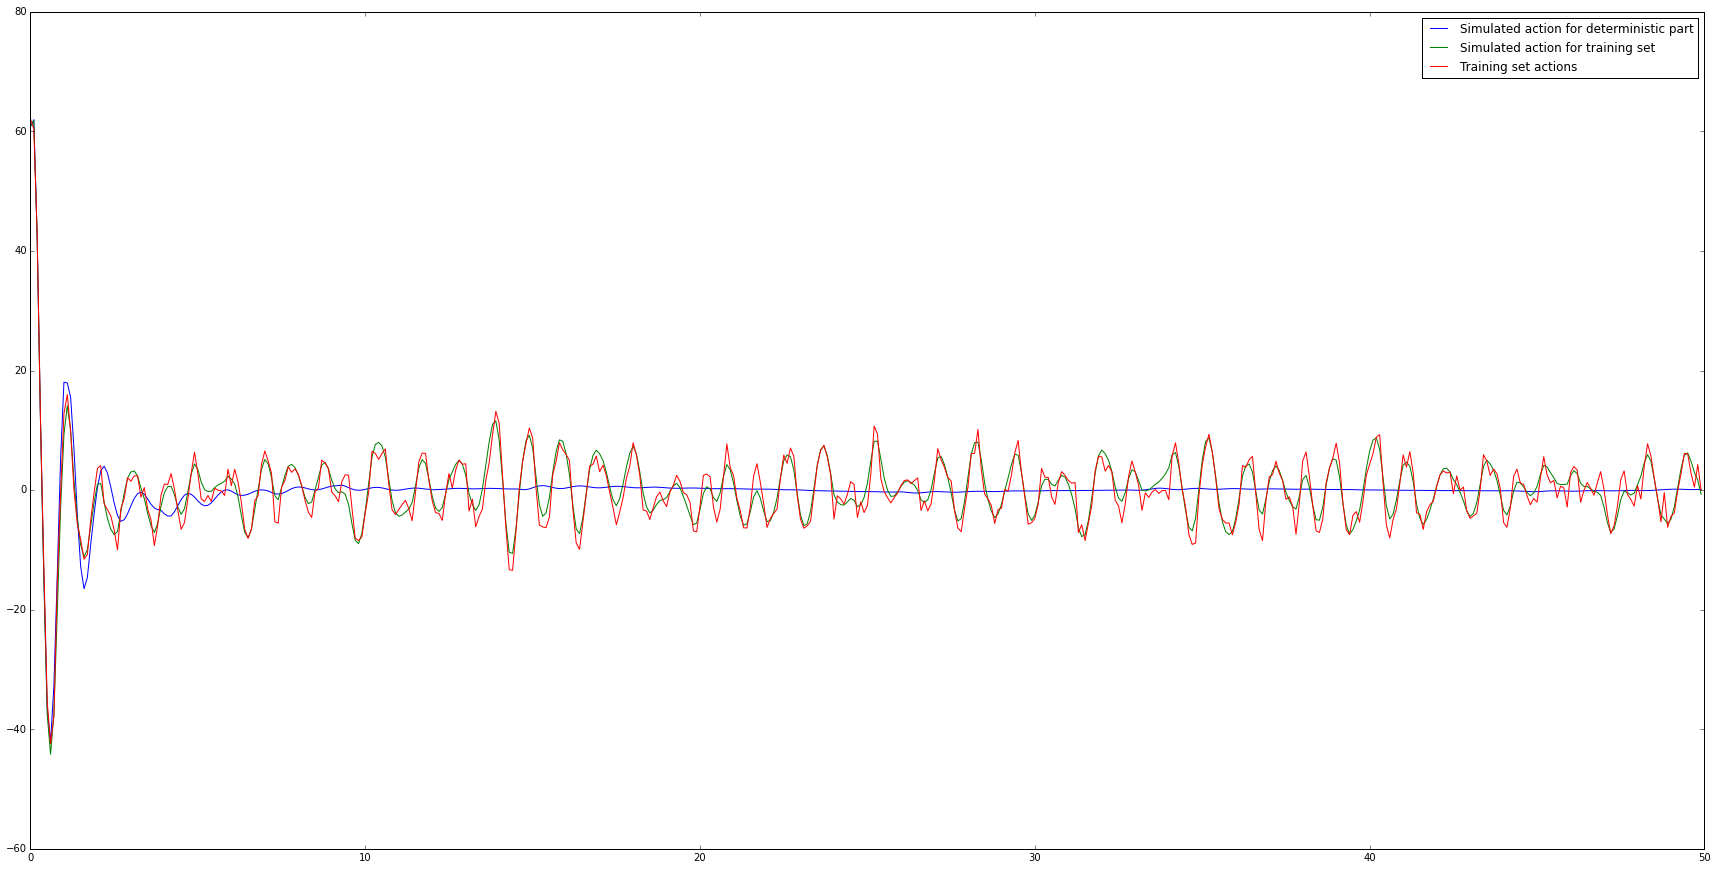

In [732]:
'''
4D. Simulate the resulting policy
'''
feed_forward = theano.function(
    inputs=[x],
    outputs=policy.output)

print Quu_choices
dt = 0.1
x_init2 = np.array([0, np.pi-np.pi/10, 0, 0,10,1])

x_sim = np.zeros([6,500])
x_sim[:,0] = x_init2

u_sim = np.zeros([500,])
u_sim[0] = feed_forward(x_sim[:,0].reshape([1,6]))

for t in range(499):
    x_sim[:,t+1] = sim_cartpole_ext(x_sim[:,t], u_sim[t], dt)
    u_sim[t+1] = feed_forward(x_sim[:,t+1].reshape([1,6]))

u_1 = np.zeros([500,])
for t in range(500):
    u_1[t] = feed_forward(train_set.get_value().T[:,t].reshape([1,6]))
    
tt = dt*np.arange(0,500)
plt.figure(figsize=(30,15))
#plt.plot(tt, u_lqr.flatten(), label="LQR action")
plt.plot(tt[:500], u_sim.flatten()[:500], label="Simulated action for deterministic part")
plt.plot(tt, u_1.flatten(), label="Simulated action for training set")
plt.plot(tt, train_u.get_value().flatten()[:500], label="Training set actions")
plt.legend()

#plt.plot(u_sim)

print x_sim[:,-1]

### 4E. Attempt train a bigger network that may be able to generalize

In [737]:
'''
4E. Initialize variables
'''
Q_ext = np.eye(6)
R_ext = np.eye(1)
x_ref_ext1 =  np.array([0, np.pi, 0, 0, 10., 1.])
u_ref_ext1 = 0.
A_ext1, B_ext1, c_ext1 = linearize_cartpole_ext(x_ref_ext1, u_ref_ext1, 0.1, 0.1)
K_ext1, P_ext1, Quu_ext1 = lqr_infinite_horizon(A_ext1, B_ext1, Q_ext, R_ext)
x_ref_ext2 =  np.array([0, np.pi, 0, 0, 11., 1.1])
u_ref_ext2 = 0.
A_ext2, B_ext2, c_ext2 = linearize_cartpole_ext(x_ref_ext2, u_ref_ext2, 0.1, 0.1)
K_ext2, P_ext2, Quu_ext2 = lqr_infinite_horizon(A_ext2, B_ext2, Q_ext, R_ext)
x_ref_ext3 =  np.array([0, np.pi, 0, 0, 12., 1.2])
u_ref_ext3 = 0.
A_ext3, B_ext3, c_ext3 = linearize_cartpole_ext(x_ref_ext3, u_ref_ext3, 0.1, 0.1)
K_ext3, P_ext3, Quu_ext3 = lqr_infinite_horizon(A_ext3, B_ext3, Q_ext, R_ext)


x_init_choices = [
    np.array([0, np.pi - np.pi/10, 0, 0, 10.,1.]),
    np.array([0, np.pi - np.pi/10, 0, 0, 12., 1.2]),
    np.array([0, np.pi - np.pi/10, 0, 0, 11,1.1]),
]


#K_choices = [K_ext1, K_ext1, K_ext1, K_ext1, K_ext1, K_ext1,] 
#             K_ext2, K_ext2, K_ext2, K_ext2, K_ext2, K_ext2]
#Quu_choices = [Quu_ext1, Quu_ext1, Quu_ext1, Quu_ext1, Quu_ext1, Quu_ext1,]
#               Quu_ext2, Quu_ext2, Quu_ext2, Quu_ext2, Quu_ext2, Quu_ext2]
K_choices = [K_ext1, K_ext2, K_ext3]
Quu_choices = [Quu_ext1, Quu_ext2, Quu_ext3]


In [ ]:
'''
4E. Train network
'''
x, policy, tr_losses, val_losses, te_losses, train_set, val_set, train_u, val_u = train_NN(
    learning_rate=0.00001, L1_reg=0.0, L2_reg=0.0001, n_epochs=40000, batch_size=100, n_layers=4, n_hidden=100, 
    LQR_controller=K_choices, LQR_start=x_init_choices, LQR_var=Quu_choices, num_traj=10, ext=True, 
    learning_rule=(10000, 0.1),
    dt=0.1, print_interval=1000, traj_size=500)

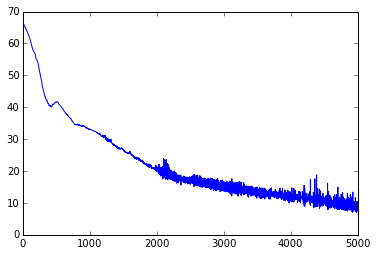

In [766]:
plt.plot(tr_losses)

[ nan  nan  nan  nan  10.   1.]


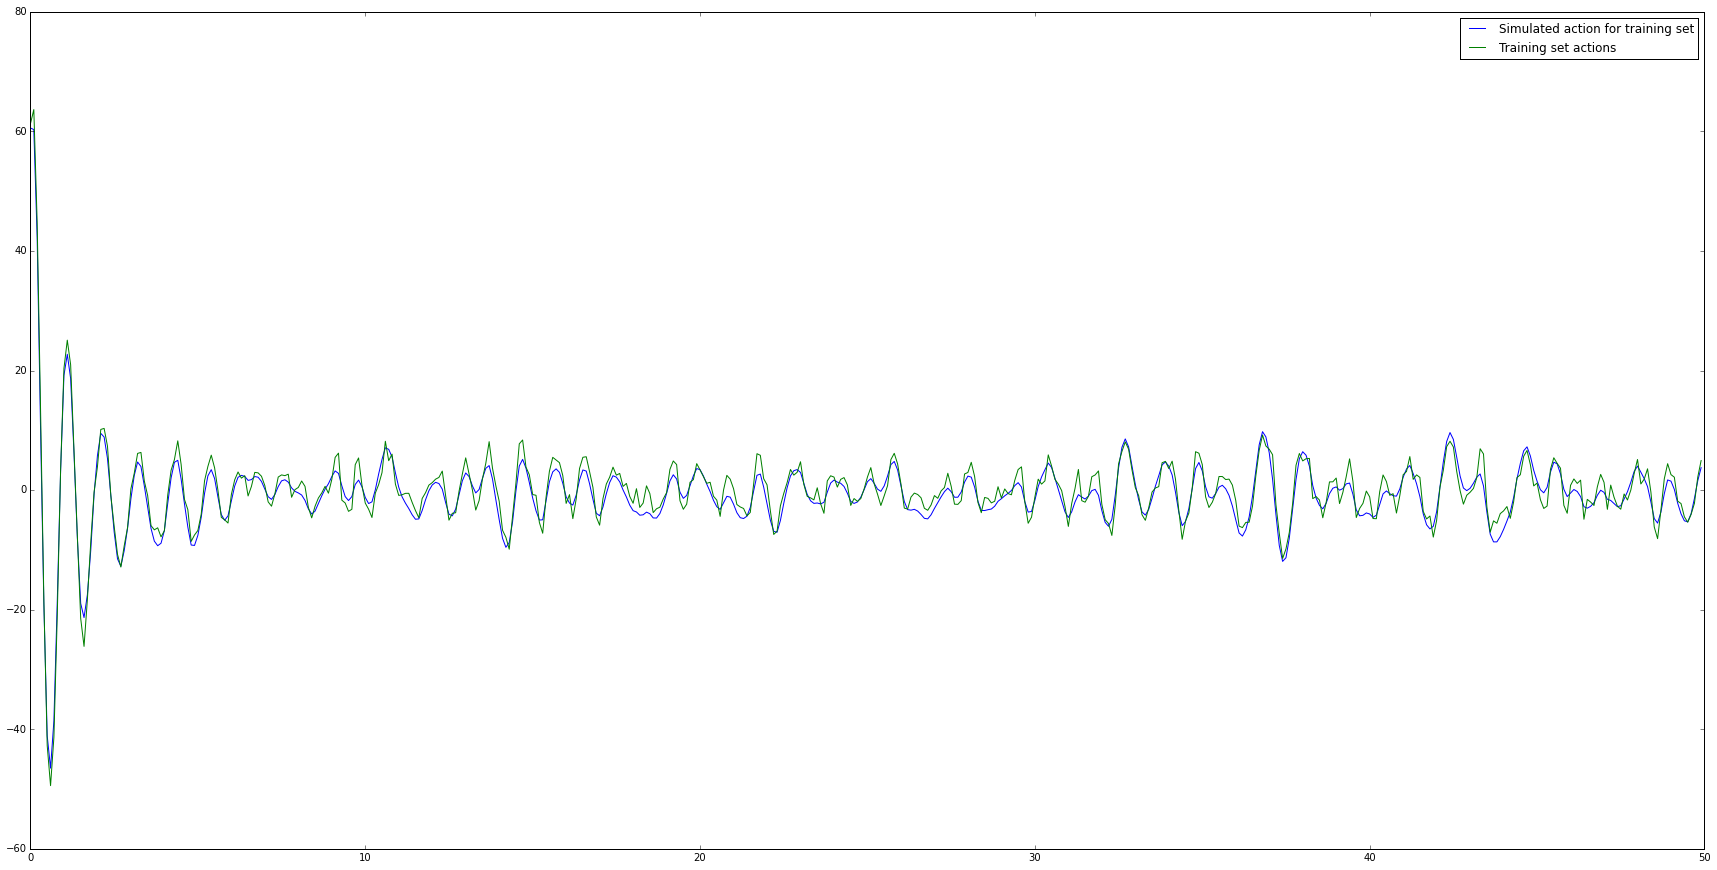

In [759]:
'''
4E. Simulate the resulting policy
'''
feed_forward = theano.function(
    inputs=[x],
    outputs=policy.output)

dt = 0.1
x_init2 = np.array([0, np.pi-np.pi/10, 0, 0,10,1])

x_sim = np.zeros([6,500])
x_sim[:,0] = x_init2

u_sim = np.zeros([500,])
u_sim[0] = feed_forward(x_sim[:,0].reshape([1,6]))

for t in range(499):
    x_sim[:,t+1] = sim_cartpole_ext(x_sim[:,t], u_sim[t], dt)
    u_sim[t+1] = feed_forward(x_sim[:,t+1].reshape([1,6]))

u_1 = np.zeros([500,])
for t in range(500):
    u_1[t] = feed_forward(train_set.get_value().T[:,t].reshape([1,6]))
    
tt = dt*np.arange(0,500)
plt.figure(figsize=(30,15))
#plt.plot(tt, u_lqr.flatten(), label="LQR action")
#plt.plot(tt[:500], u_sim.flatten()[:500], label="Simulated action for deterministic part")
plt.plot(tt, u_1.flatten(), label="Simulated action for training set")
plt.plot(tt, train_u.get_value().flatten()[:500], label="Training set actions")
plt.legend()

#plt.plot(u_sim)

print x_sim[:,-1]